# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# install missingno library to visualize missing data
!pip install missingno

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime
import time

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, when
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

import re

In [3]:
# create a Spark session
spark = SparkSession.builder\
    .appName("Sparkify Project")\
    .getOrCreate()

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load dataset

In [5]:
# Load sparkify_event dataset
dataset_name = "mini_sparkify_event_data.json"
df_sparkify = spark.read.json(dataset_name)

##### Some initial information of the dataset

In [6]:
# Size of the dataset
print("Size of the dataset: {} rows, {} columns".format(df_sparkify.count(), len(df_sparkify.columns)))

Size of the dataset: 286500 rows, 18 columns


In [7]:
# The Schema of the dataset
print("The Schema of the dataset:")
df_sparkify.printSchema()

The Schema of the dataset:
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Some descriptions of the dataset
print("Some descriptions of the dataset:")
df_sparkify.describe().show()

Some descriptions of the dataset:
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           

In [9]:
# Get a visualization of the dataset by switching to pandas
import pandas as pd
df_sparkify_temp = pd.DataFrame(df_sparkify.take(5), columns=df_sparkify.columns)
df_sparkify_temp

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [10]:
# Checking null values of each columns
print("Number of null values of each column")
print(df_sparkify.toPandas().isnull().sum())

Number of null values of each column
artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64


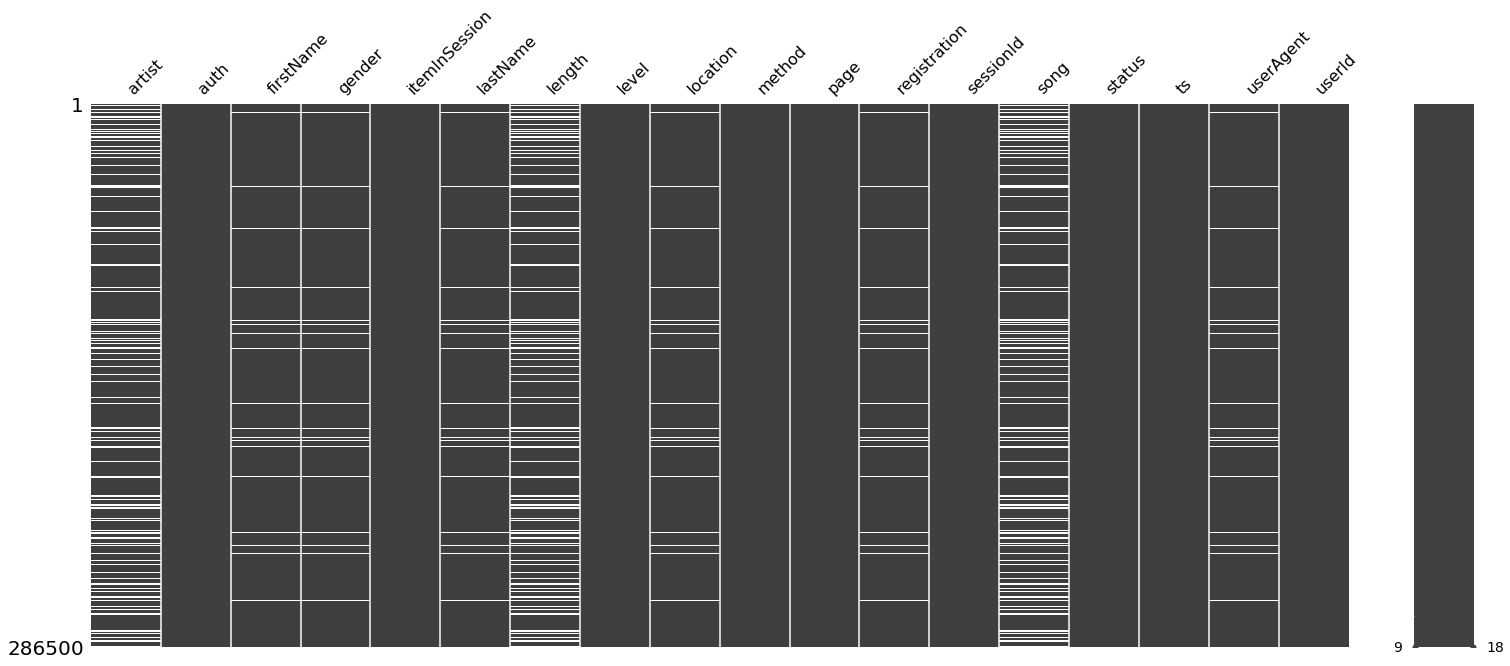

In [11]:
# Visualize null value by missingno library
msno.matrix(df_sparkify.toPandas());

The `userId` and `sessionId` columns dont't contain null values. In contrast, many of the other columns include null values.

## Clean dataset

We must look at the blank `userID` or `sessionId` rows.

In [12]:
print("We have {} userID rows and {} sessionId rows are empty".format(df_sparkify.filter(df_sparkify['userId']=='').count(), df_sparkify.filter(df_sparkify['sessionId']=='').count()))

We have 8346 userID rows and 0 sessionId rows are empty


Numerous observations (i.e. rows) have userId fields that are empty and The sessionId variable for each observation contains a valid value.

Delete all userID rows that are empty.

In [13]:
df_sparkify = df_sparkify.filter(df_sparkify["userID"] != "")

In [14]:
print("After removing empty userID rows, the dataset remain {} rows".format(df_sparkify.count()))

After removing empty userID rows, the dataset remain 278154 rows


In [15]:
# We also need to restyle of `time` column to timestamp
timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df_sparkify = df_sparkify.withColumn("time", timestamp(df_sparkify.ts))

In [16]:
df_sparkify_temp = pd.DataFrame(df_sparkify.take(5), columns=df_sparkify.columns)
df_sparkify_temp

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Churn is outlined as users who have canceled Sparkify (users who have "Cancelled Confirmation" page events)

In [17]:
# All values of page column
df_sparkify.select("page").dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [18]:
print("Total number of users who left (churned users): {}".format(df_sparkify.select(["userId", "page"]).where(df_sparkify.page == "Cancellation Confirmation").count()))

Total number of users who left (churned users): 52


By assigning a 1 if a user has been churned and a 0 if they have not, I construct the flag for churned users. The target column for a later modeling stage will be created using this flag and given the name "churn."

In [19]:
active_churned = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [20]:
# Create churned column
df_sparkify = df_sparkify.withColumn("churned", active_churned("page"))
df_sparkify_temp = pd.DataFrame(df_sparkify.take(5), columns=df_sparkify.columns)
df_sparkify_temp

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time,churned
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,0


In [21]:
# All users who churned (active_churned = 1)
# function for converting Row object to string
udf_c = lambda x, y: x.asDict()[y]
churned = df_sparkify.filter(df_sparkify.churned == 1).groupby(df_sparkify.userId).count().orderBy(df_sparkify.userId).collect()
churned_list = list(map(udf_c, churned, ['userId' for i in range(len(churned))]))
print(churned_list)

['100001', '100003', '100005', '100006', '100007', '100009', '100011', '100012', '100013', '100014', '100015', '100017', '100019', '100021', '100022', '100023', '100024', '100025', '101', '103', '105', '106', '12', '121', '122', '125', '129', '143', '17', '18', '200001', '200011', '200015', '200016', '200017', '200018', '200020', '200021', '200024', '28', '29', '3', '300001', '300007', '32', '51', '53', '54', '58', '70', '73', '87']


In [22]:
# All users who churned (active_churned = 0)
# function for converting Row object to string
users = df_sparkify.select(["userId"]).dropDuplicates().sort("userId").collect()
usersList = list(map(udf_c, users, ['userId' for i in range(len(users))]))
not_churned = [c for c in usersList if not c in churned_list]
print(not_churned)

['10', '100', '100002', '100004', '100008', '100010', '100016', '100018', '102', '104', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '123', '124', '126', '127', '128', '13', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '16', '19', '2', '20', '200002', '200003', '200004', '200005', '200006', '200007', '200008', '200009', '200010', '200012', '200014', '200019', '200022', '200023', '200025', '21', '22', '23', '24', '25', '26', '27', '30', '300002', '300003', '300004', '300005', '300006', '300008', '300009', '300010', '300011', '300012', '300013', '300014', '300015', '300016', '300017', '300018', '300019', '300020', '300021', '300022', '300023', '300024', '300025', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '49', '5', '50', '52', '55', '56',

I will arrange the records for each user in descending order based on the timestamp and sum the values in the churn column

In [23]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_sparkify = df_sparkify.withColumn("churned", Fsum("churned").over(windowval))
df_churn = df_sparkify.select(['userId', 'churned']).dropDuplicates().groupBy('churned').count()

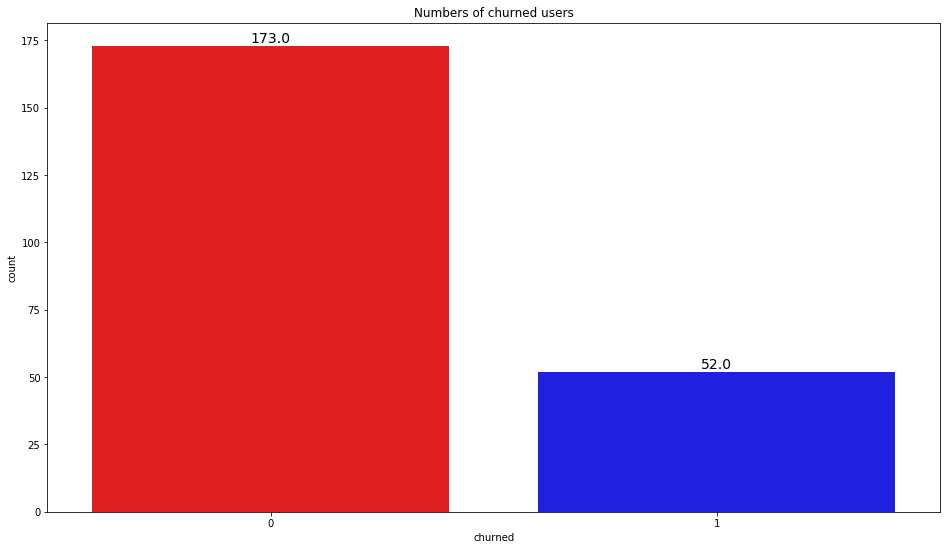

In [24]:
import seaborn as sb
df_churn = df_churn.toPandas()
plt.figure(figsize = [16, 9]);
plot = sns.barplot(data=df_churn, x="churned", y="count",  palette=['r', 'b'])
plt.title("Numbers of churned users");

# Iterate over the bars in the plot
for p in plot.patches:
    # Get the height of the bar
    height = p.get_height()
    # Add an annotation to the plot at the center of the bar
    plot.axes.text(p.get_x() + p.get_width() / 2, height, height, ha='center', va='bottom', fontsize=14, color='black')

In [25]:
df_churn

,churned,count
0,0,173
1,1,52


The chart shows that there are only 52 churned users and 173 stayed users. This imbalance in the data is important to consider when building a model, as it could affect the model's performance

### Preliminary Analysis

#### Time

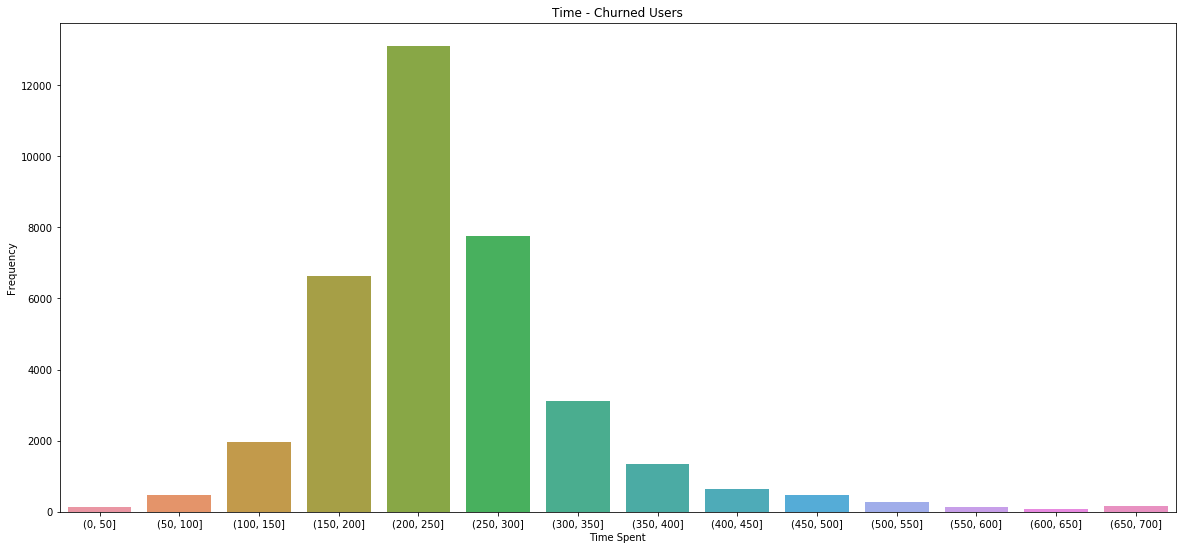

In [26]:
# Time - Churned Users
churned_time = df_sparkify.filter(df_sparkify.churned==1).toPandas()
churned_time = churned_time[np.isfinite(churned_time['length'])]
plt.figure(figsize = [20, 9]);

# Create the bins using the cut function
bins = pd.cut(churned_time['length'], bins=range(0, 701, 50))

# Add the bins column to the dataframe
churned_time['bins'] = bins

# Create the countplot
plot = sns.countplot(data=churned_time, x='bins')

# Set the x-axis and y-axis labels
plot.set_xlabel('Time Spent')
plot.set_ylabel('Frequency')

# Add a title to the plot
plot.set_title('Time - Churned Users');

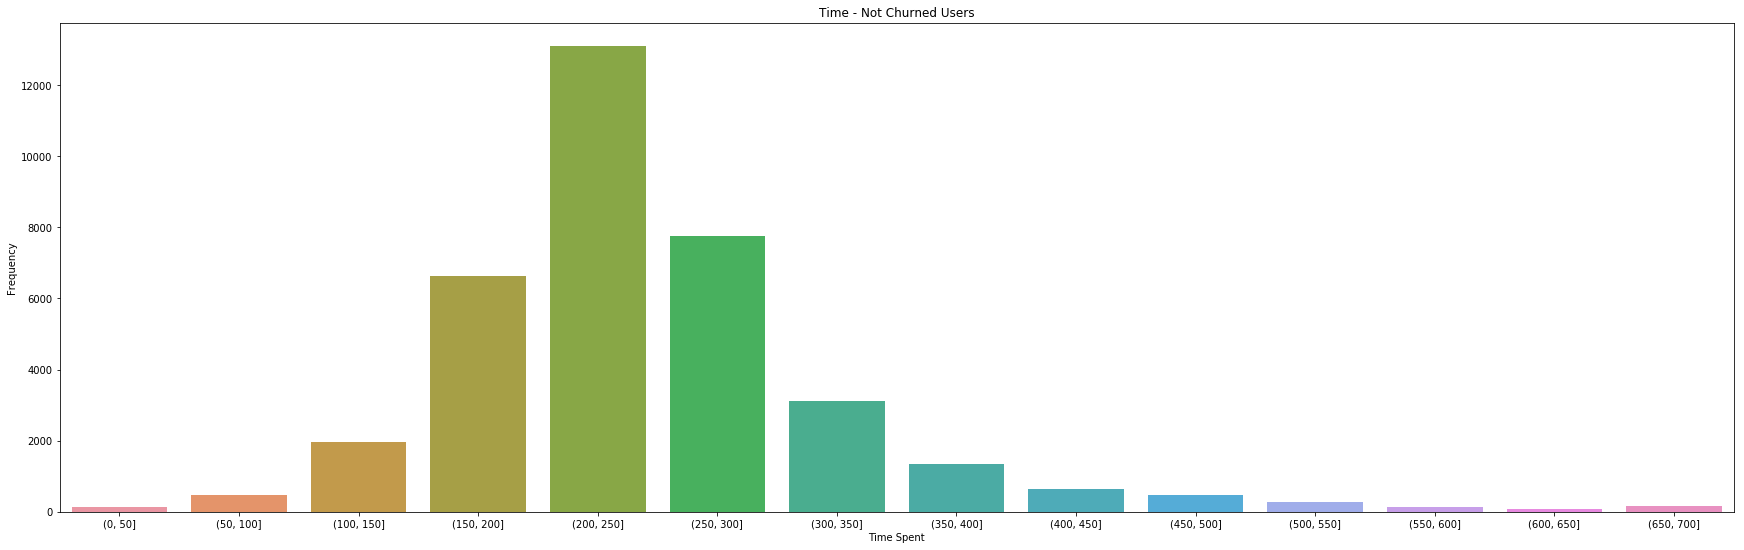

In [27]:
# Time - Not Churned Users
not_churned_time = df_sparkify.filter(df_sparkify.churned==1).toPandas()
not_churned_time = not_churned_time[np.isfinite(not_churned_time['length'])]
plt.figure(figsize = [30, 9]);

# Create the bins using the cut function
bins = pd.cut(not_churned_time['length'], bins=range(0, 701, 50))

# Add the bins column to the dataframe
not_churned_time['bins'] = bins

# Create the countplot
plot = sns.countplot(data=not_churned_time, x='bins')

# Set the x-axis and y-axis labels
plot.set_xlabel('Time Spent')
plot.set_ylabel('Frequency')

# Add a title to the plot
plot.set_title('Time - Not Churned Users');

There is no significant difference in the amount of time spent between the two groups, meaning that this factor is not likely to be helpful in predicting churn

#### Level

In [28]:
churned_level = df_sparkify.select(['userId', 'churned', 'level']).dropDuplicates().groupBy('level','churned').count()
churned_level = churned_level.toPandas()
churned_level.head()

,level,churned,count
0,free,0,149
1,paid,0,129
2,free,1,46
3,paid,1,36


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


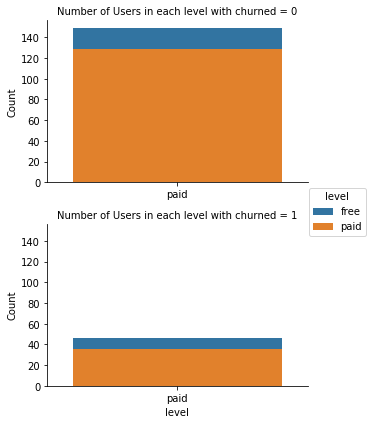

In [29]:
# Create a faceted plot with the 'churned' column on the rows and the 'level' column on the hue
plt.figure(figsize=[16, 9])
g = sns.FacetGrid(data=churned_level, row='churned', hue='level', aspect=1.5);

# Use the barplot function to plot the count values
g.map(sns.barplot, 'level', 'count');


# Add a legend to the plot
g.add_legend();

# Set the titles for the rows and the plot
g.set_titles("Number of Users in each level with churned = {row_name}");
g.set(ylabel='Count');

According to the chart, there is a slight difference between free users and paid users in terms of churn. More free users have churned compared to paid users. However, this information alone is not sufficient for predicting churn. I will continue exploring other features to find more insights

#### Gender

In [30]:
churned_gender = df_sparkify.select(['userId', 'churned', 'gender']).dropDuplicates().groupBy('gender','churned').count()
churned_gender.show()
churned_gender = churned_gender.toPandas()

+------+-------+-----+
|gender|churned|count|
+------+-------+-----+
|     F|      0|   84|
|     F|      1|   20|
|     M|      0|   89|
|     M|      1|   32|
+------+-------+-----+



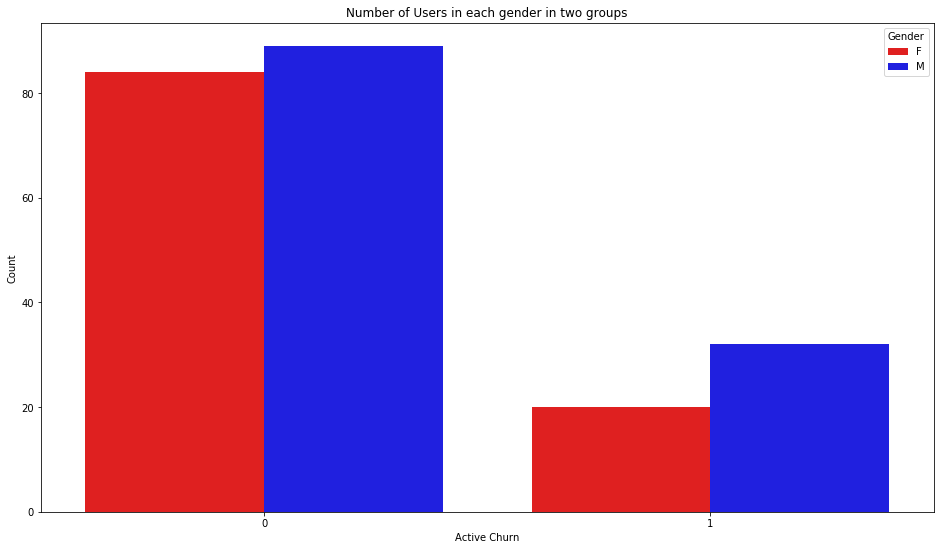

In [31]:
# Convert the 'count' column to a numeric type
plt.figure(figsize=[16, 9])
churned_gender['count'] = pd.to_numeric(churned_gender['count'])

# Create a bar chart with the 'level' column on the x-axis and the 'count' column on the y-axis
plot = sns.barplot(data=churned_gender, x='churned', y='count', hue='gender',  palette=['r', 'b'])
, 
# Add a legend to the plot
plot.legend(loc='upper right', title='Gender')

# Set the x-axis label
plot.set(xlabel='Active Churn', ylabel='Count')

# Set the title of the plot
plot.set_title('Number of Users in each gender in two groups');

.There is a higher proportion of male users who churn compared to female users

#### Page

In [32]:
churned_page = df_sparkify.select(['userId', 'churned', 'page']).dropDuplicates().groupBy('page','churned').count()
churned_page = churned_page.toPandas()
churned_page.head(10)

,page,churned,count
0,Settings,0,152
1,Thumbs Down,1,48
2,Thumbs Up,1,50
3,Add to Playlist,1,50
4,Error,1,22
5,About,1,31
6,Thumbs Down,0,155
7,Roll Advert,1,50
8,Home,0,172
9,Cancellation Confirmation,1,52


In [33]:
churned_count_df = churned_page[churned_page['churned']==1].sum()
stay_count_df = churned_page[churned_page['churned']==0].sum()

In [34]:
churned_page['rate'] = np.where(
    churned_page['churned'] == 0, churned_page['count']/stay_count_df['count'], np.where(
    churned_page['churned'] == 1, churned_page['count']/churned_count_df['count'],churned_page['count']/churned_count_df['count'])) 

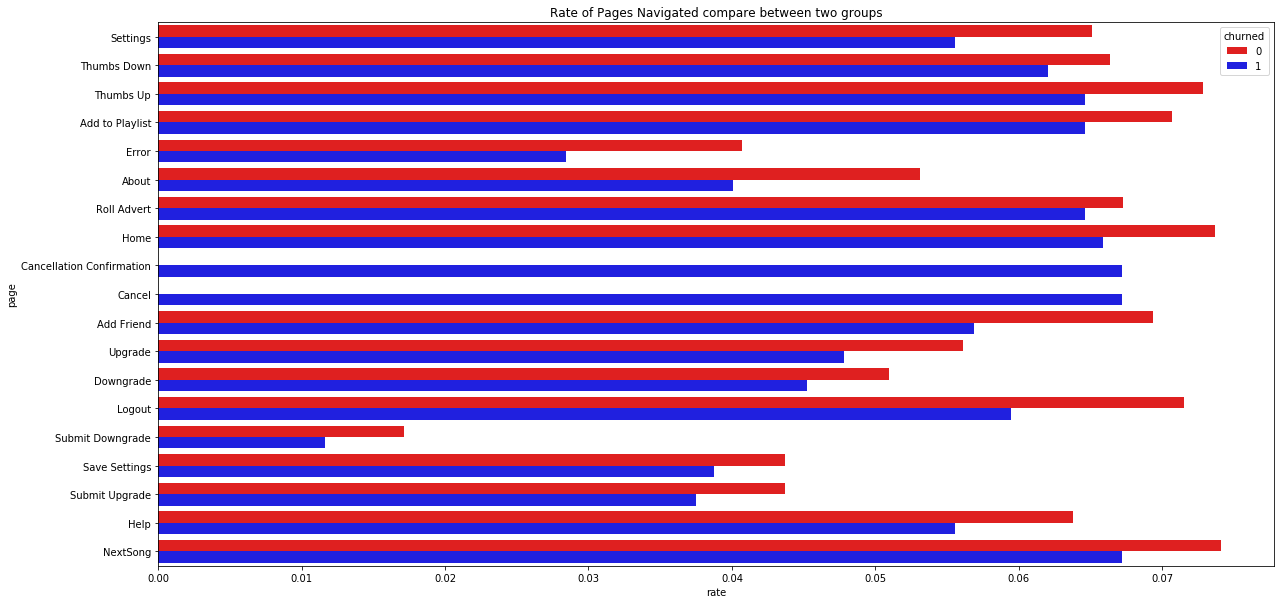

In [35]:
# plot the pages by churned
plt.figure(figsize=[20,10])
sns.barplot(data = churned_page, x = 'rate', y = 'page', hue = 'churned', palette=['r', 'b'])
plt.title('Rate of Pages Navigated compare between two groups');

According to the above figure, the most popular action for both those who stayed and those who left was to skip to the next song. We can also see that churned users are more likely to roll the ad and thumbs down music. Those that were more inclined to stay did more thumbs up, added friends, and added songs to their playlist.

#### Songs Per Session

In [36]:
songs_per_sess = df_sparkify.filter(df_sparkify.page == "NextSong").dropDuplicates().groupBy('sessionId','churned').count()

In [37]:
songs_per_sess.groupby('churned').agg({"count":"avg"}).show()

+-------+-----------------+
|churned|       avg(count)|
+-------+-----------------+
|      0| 93.3369036027264|
|      1|79.81140350877193|
+-------+-----------------+



In [38]:
df_songs = songs_per_sess.groupby('churned').agg({"count":"avg"}).toPandas()

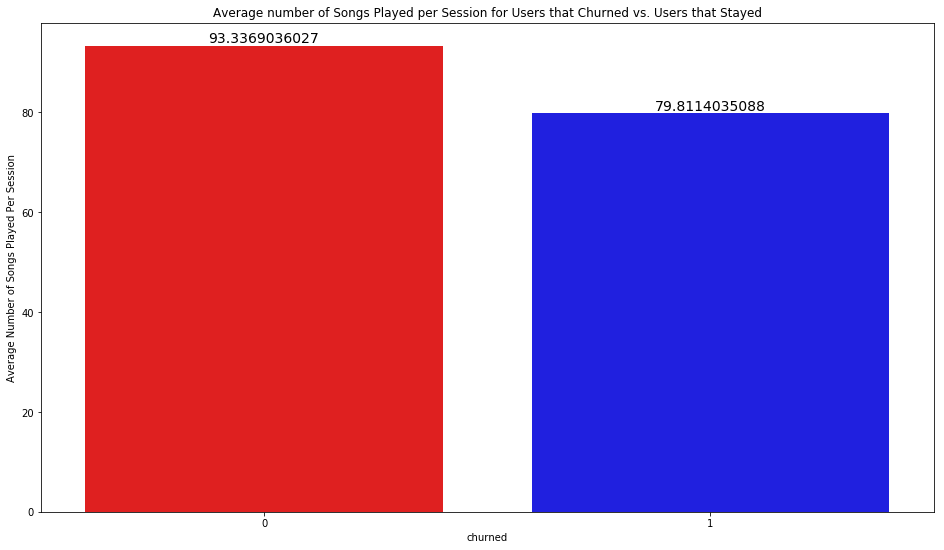

In [39]:
plt.figure(figsize = [16, 9]);
plot = sns.barplot(data=df_songs, x="churned", y="avg(count)",  palette=['r', 'b'])
plt.title("Average number of Songs Played per Session for Users that Churned vs. Users that Stayed")
plt.ylabel("Average Number of Songs Played Per Session");

# Iterate over the bars in the plot
for p in plot.patches:
    # Get the height of the bar
    height = p.get_height()
    # Add an annotation to the plot at the center of the bar
    plot.axes.text(p.get_x() + p.get_width() / 2, height, height, ha='center', va='bottom', fontsize=14, color='black')

According to the graph, users that churn from Sparkify listen to less songs on average per session.

#### Browser and Operating System

In [40]:
os_df = df_sparkify.select("userId", "userAgent", "churned").dropDuplicates(['userId']).toPandas()
os_df.head()

,userId,userAgent,churned
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1


In [41]:
list_os = ["Windows", "Mac", "Linux", "iPhone", "iPad"]
os_df['os'] = os_df.userAgent.str.extract('(?i)({0})'.format('|'.join(list_os)))

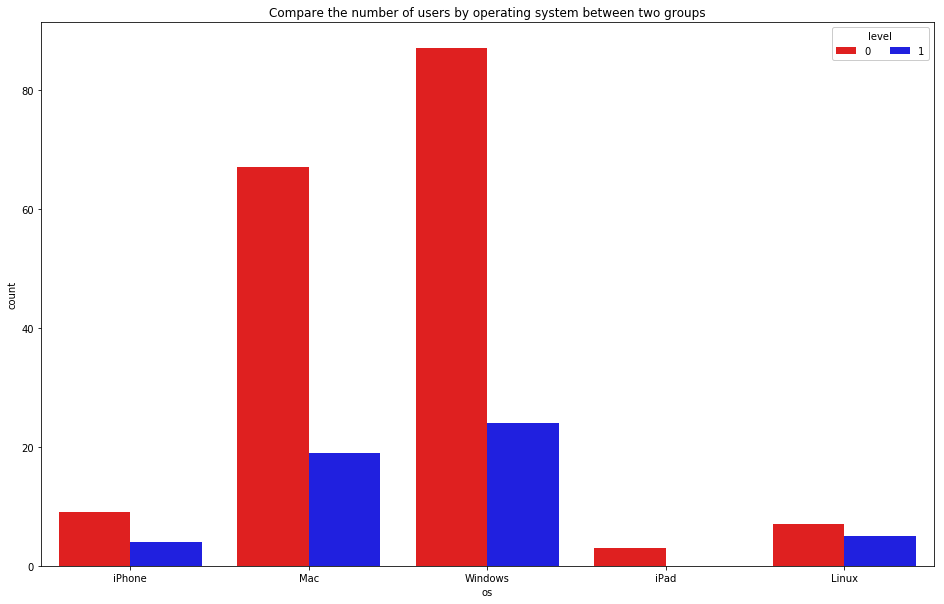

In [42]:
plt.figure(figsize=[16,10])
sns.countplot(data = os_df, x = 'os', hue ='churned', palette=['r', 'b'])
plt.title('Compare the number of users by operating system between two groups')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

We can see that Windows and Mac are the two operating systems with the most users.

In [43]:
list_browser = ["Chrome", "Firefox", "Safari", "Trident"]
os_df['browser'] = os_df.userAgent.str.extract('(?i)({0})'.format('|'.join(list_browser)))

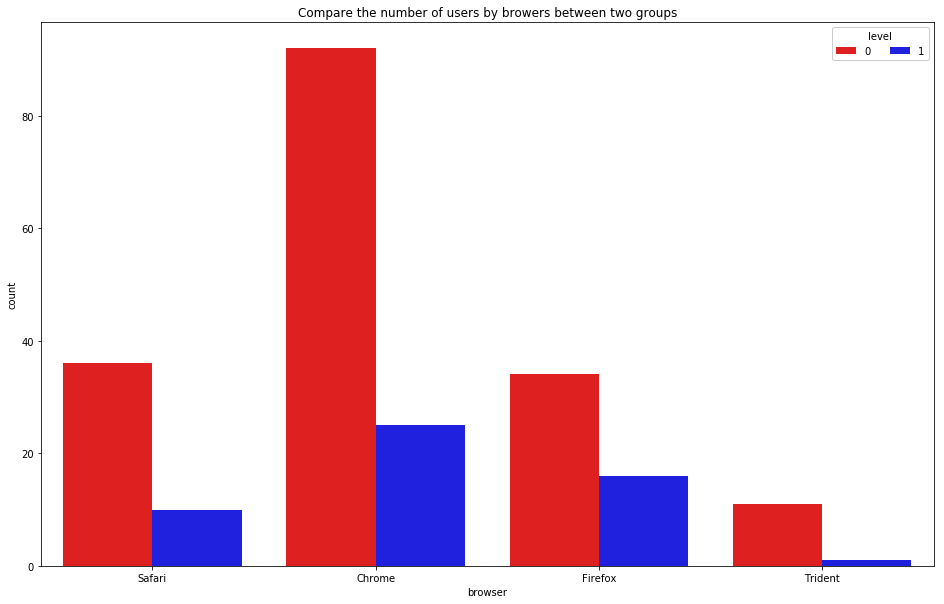

In [44]:
plt.figure(figsize=[16,10])
sns.countplot(data = os_df, x = 'browser', hue ='churned', palette=['r','b'])
plt.title('Compare the number of users by browers between two groups')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Chrome was the most popular browser. Firefox users had the greatest churn rate. Trident had the lowest user churn rate. There is no obvious issue with browsers that is driving customers away. As a result, this will not be incorporated into our model.

#### Location

In [45]:
# get last two characters
get_state = udf(lambda x: x[-2:])
# create state column
df_state = df_sparkify.withColumn("state", get_state(df_sparkify.location))
df_state = df_state.select("state", "userId", "churned").dropDuplicates().groupby("state", "churned").count()
# convert to pandas 
df_state_pd = df_state.toPandas()
# check that create state column worked
df_state_pd.head()

,state,churned,count
0,AL,0,4
1,IL,0,8
2,AZ,1,2
3,OH,0,1
4,AL,1,2


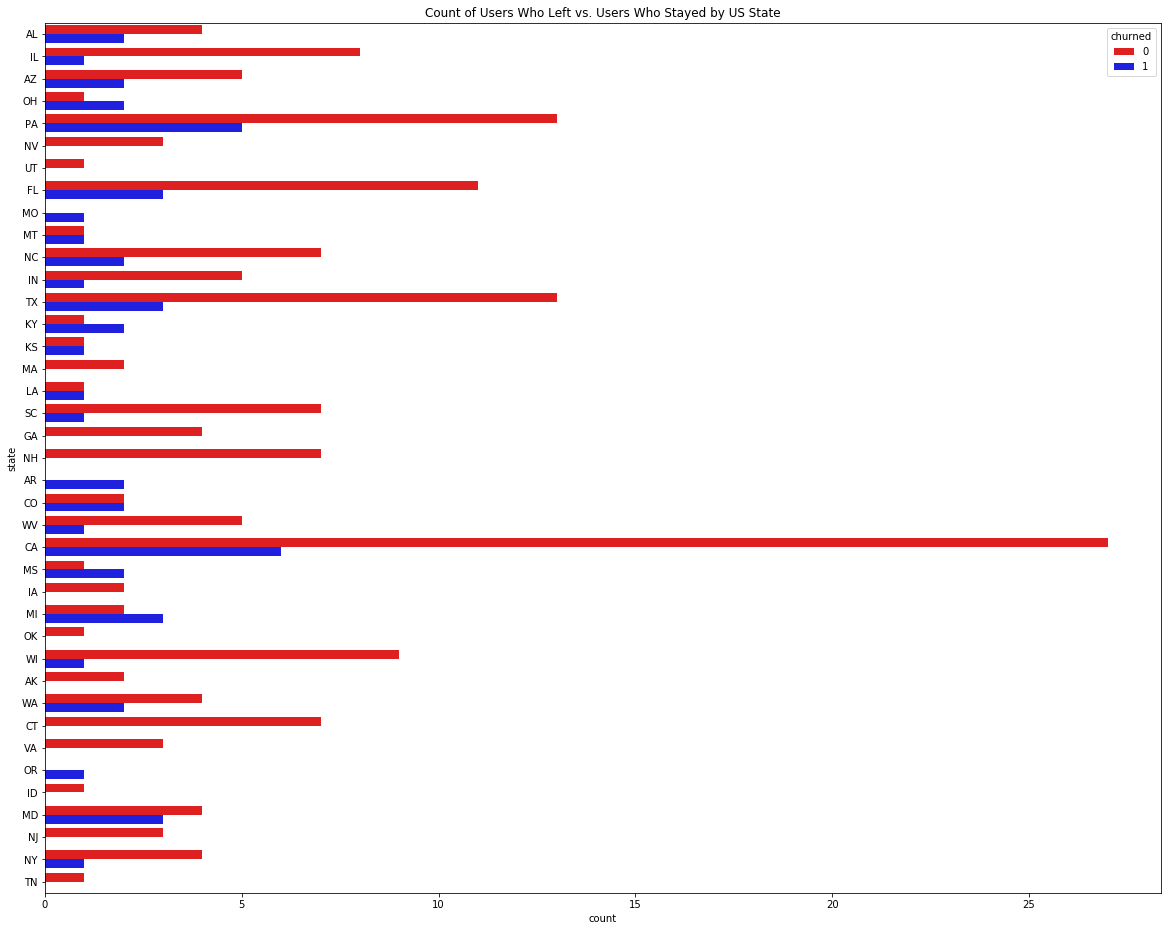

In [46]:
# plot 
plt.figure(figsize=[20,16])
sns.barplot(data = df_state_pd, x = 'count', y = 'state', hue = 'churned', palette=['r','b'])
plt.title('Count of Users Who Left vs. Users Who Stayed by US State');

The majority of users were from California. More users left than stayed in Michigan, Kentucky, and Ohio. When it comes to modeling, this may be tough to develop a meaningful feature for. 

#### Days Since Registration for Sparkify


In [47]:
days_df = df_sparkify.select(['userId', 'registration', 'ts', 'churned']).dropDuplicates().sort('userId')
# order by last timestamp
w = Window.partitionBy("userId").orderBy(desc("ts"))
# create a rank with the most recent timestamp as rank number 1
days_df = days_df.withColumn("Rank", dense_rank().over(w))
days_df.show()

+------+-------------+-------------+-------+----+
|userId| registration|           ts|churned|Rank|
+------+-------------+-------------+-------+----+
|    10|1538159495000|1542631788000|      0|   1|
|    10|1538159495000|1542631753000|      0|   2|
|    10|1538159495000|1542631690000|      0|   3|
|    10|1538159495000|1542631518000|      0|   4|
|    10|1538159495000|1542631517000|      0|   5|
|    10|1538159495000|1542631090000|      0|   6|
|    10|1538159495000|1542630866000|      0|   7|
|    10|1538159495000|1542630637000|      0|   8|
|    10|1538159495000|1542630407000|      0|   9|
|    10|1538159495000|1542630394000|      0|  10|
|    10|1538159495000|1542630248000|      0|  11|
|    10|1538159495000|1542630247000|      0|  12|
|    10|1538159495000|1542630029000|      0|  13|
|    10|1538159495000|1542629861000|      0|  14|
|    10|1538159495000|1542629636000|      0|  15|
|    10|1538159495000|1542629464000|      0|  16|
|    10|1538159495000|1542629238000|      0|  17|


In [48]:
days_df = days_df.filter(days_df.Rank == 1).drop(days_df.Rank)
# minus the registration from ts 
days_df = days_df.withColumn("delta_days", (days_df['ts']) - (days_df['registration']))
days_df = days_df.withColumn('days',(days_df['delta_days']/1000/3600/24))
df_days_pd = days_df.toPandas()
df_days_pd.head()

,userId,registration,ts,churned,delta_days,days
0,10,1538159495000,1542631788000,0,4472293000,51.762650
1,100,1537982255000,1543587349000,0,5605094000,64.873773
2,100001,1534627466000,1538498205000,1,3870739000,44.800220
3,100002,1529934689000,1543799476000,0,13864787000,160.472072
4,100003,1537309344000,1539274781000,1,1965437000,22.748113


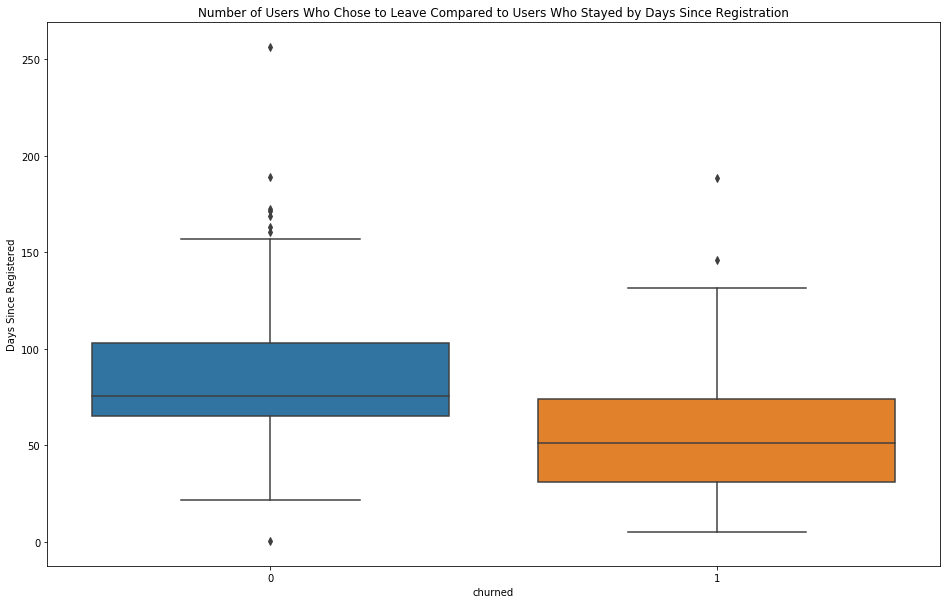

In [49]:
plt.figure(figsize=[16,10])
sns.boxplot(data = df_days_pd, x = 'churned', y ='days')
plt.title('Number of Users Who Chose to Leave Compared to Users Who Stayed by Days Since Registration')
plt.ylabel("Days Since Registered");

Longer-standing Sparkify users were often more inclined to stick around. More recently registered users were more likely to churn.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

The features selected to keep for purpose label for churned users:
- Number of Artist.
- Gender of users: Male or Female.
- Number of songs/session.
- Length of songs/session.
- Level: Paid or Free.
- Number of each actions: Roll Advert, "ThumbsUp", "ThumbsDown", "InviteFriends", "downgrades"
- The user account age.

I will create a label called 'churn' by combining these elements together and will use this label as the target for our analysis. The resulting data frame will have a row for each unique user and will include information about each user. Before using this data frame with machine learning algorithms, I will first vectorize, standardize. Additionally, I will convert any categorical variables to numerical values to prepare the data for modeling.

### Number of Artist.

In [50]:
number_of_artists = df_sparkify.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_of_aritst")
number_of_artists.show(5)

+------+-------------+
|userId|num_of_aritst|
+------+-------------+
|100010|          253|
|200002|          340|
|   125|            9|
|    51|         1386|
|   124|         2233|
+------+-------------+
only showing top 5 rows



### Gender of users: Male or Female.

In [51]:
# Swicth gender to numeric values by assign value "0" with Male and "0" with Female
gender = df_sparkify.select(['userId', 'gender']).dropDuplicates()
gender = gender.withColumn('gender', when(col('gender') == 'M', 0).otherwise(1))
gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
+------+------+
only showing top 10 rows



### Number of songs/session.

In [52]:
num_of_song = df_sparkify.filter(df_sparkify.page == "NextSong").groupBy('userId','sessionId').count()
num_of_song = num_of_song.groupby('userId').agg({"count":"avg"})
num_of_song = num_of_song.withColumnRenamed("avg(count)", "avg_song")
num_of_song.show(5)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



### Length of songs/session.

In [53]:
length_of_song = df_sparkify.filter(df_sparkify.page=='NextSong').select('userId', 'sessionId', 'length')
length_of_song = length_of_song.withColumn('length', (length_of_song.length / 3600))
length_of_song = length_of_song.groupBy('userId', 'sessionId').sum('length')
length_of_song = length_of_song.groupBy('userId').agg(
                        F.avg('sum(length)').alias('mean_length'), 
                        F.stddev('sum(length)').alias('stdev_length')).na.fill(0)
length_of_song.show(10)

+------+------------------+------------------+
|userId|       mean_length|      stdev_length|
+------+------------------+------------------+
|100010|2.6563848154761907|1.5940891633984364|
|200002|       4.352262775| 3.481087253628621|
|   125|0.5803091944444445|               0.0|
|    51|14.535440077777778|11.600663366034107|
|   124|10.042778698313494| 9.370878101268762|
|     7|1.5092891706349203|1.7372572756564078|
|    54| 5.645594599523808|6.7241639034102025|
|    15| 9.470389004166666| 6.159367750898716|
|   155|  9.20274499537037| 6.528671599395436|
|100014| 3.134420003703703|1.7543652306205215|
+------+------------------+------------------+
only showing top 10 rows



### Level: Paid or Free.

In [54]:
level = df_sparkify.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
level = level.withColumn("Rank", dense_rank().over(w))
level.show(10)

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
+------+-----+-------------+----+
only showing top 10 rows



In [55]:
# Swicth level to numeric values by assign value "0" with Free and "1" with Paid
level = level.filter(level.Rank == 1).drop(level.Rank)
level = level.drop('ts')
level = level.withColumn('level', when(col('level') == 'free', 0).otherwise(1))
level.show(10)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
+------+-----+
only showing top 10 rows



### Number of each actions: Roll Advert, "ThumbsUp", "ThumbsDown", "InviteFriends", "downgrades"

In [56]:
def number_of_actions(df_sparkify, action_name, page):
    actions = df_sparkify.select(["userId", "page"])
    actions_flag = udf(lambda x: 1 if x == page else 0, IntegerType())
    actions = actions.withColumn(action_name, actions_flag("page"))
    actions = actions.groupby('userId').sum(action_name)
    return actions

In [57]:
# Roll Advert
roll_advert = number_of_actions(df_sparkify, "roll_advert", "Roll Advert")
roll_advert.show(5)

+------+----------------+
|userId|sum(roll_advert)|
+------+----------------+
|100010|              52|
|200002|               7|
|   125|               1|
|    51|               0|
|   124|               4|
+------+----------------+
only showing top 5 rows



In [58]:
# Thumbs Up
thumbs_up = number_of_actions(df_sparkify, "thumbs_up", "Thumbs Up")
thumbs_up.show(5)

+------+--------------+
|userId|sum(thumbs_up)|
+------+--------------+
|100010|            17|
|200002|            21|
|   125|             0|
|    51|           100|
|   124|           171|
+------+--------------+
only showing top 5 rows



In [59]:
# Thumbs Down
thumbs_down = number_of_actions(df_sparkify, "thumbs_down", "Thumbs Down")
thumbs_down.show(5)

+------+----------------+
|userId|sum(thumbs_down)|
+------+----------------+
|100010|               5|
|200002|               6|
|   125|               0|
|    51|              21|
|   124|              41|
+------+----------------+
only showing top 5 rows



In [60]:
# Invite Friends
invite_fen = number_of_actions(df_sparkify, "invite_fen", "Add Friend")
invite_fen.show(5)

+------+---------------+
|userId|sum(invite_fen)|
+------+---------------+
|100010|              4|
|200002|              4|
|   125|              0|
|    51|             28|
|   124|             74|
+------+---------------+
only showing top 5 rows



In [61]:
# Downgrade
down_grade = number_of_actions(df_sparkify, "down_grade", "Downgrade")
down_grade.show(5)

+------+---------------+
|userId|sum(down_grade)|
+------+---------------+
|100010|              0|
|200002|              5|
|   125|              0|
|    51|             23|
|   124|             41|
+------+---------------+
only showing top 5 rows



In [62]:
### Number of songs added to playlist
playlist = number_of_actions(df_sparkify, "playlist", "Add to Playlist")
playlist.show(5)

+------+-------------+
|userId|sum(playlist)|
+------+-------------+
|100010|            7|
|200002|            8|
|   125|            0|
|    51|           52|
|   124|          118|
+------+-------------+
only showing top 5 rows



### The user account age.

In [63]:
account_age = df_sparkify.select(['userId', 'registration', 'ts', 'churned']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
account_age = account_age.withColumn("Rank", dense_rank().over(w))
account_age = account_age.filter(account_age.Rank == 1).drop(account_age.Rank)
account_age = account_age.withColumn("delta", (account_age['ts']) - (account_age['registration']))
account_age = account_age.withColumn('account_age',(account_age['delta']/1000/3600/24))
account_age = account_age.select("userId", "account_age")
account_age.show(5)

+------+------------------+
|userId|       account_age|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



### Assemble all feature

In [64]:
all_features = [number_of_artists, gender, num_of_song, length_of_song, 
            level, roll_advert, thumbs_up, thumbs_down, invite_fen,
           down_grade, playlist, account_age]

all_features_name = ["number_of_artists", "gender", "num_of_song", "length_of_song", 
            "level", "roll_advert", "thumbs_up", "thumbs_down", "invite_fen",
           "down_grade", "playlist", "account_age"]

In [65]:
### Label of churned user
churned_pos = df_sparkify.select("userId", "churned").dropDuplicates().groupby("userId", "churned").count()
churned_pos = churned_pos.drop('count')
churned_pos = churned_pos.withColumnRenamed("churned", "label")
churned_pos.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [66]:
# Create the initial assemble_df
assemble_df = churned_pos
def collect_feature(assemble_df, feature):
    assemble_df = assemble_df.join(feature, "userId")
    return assemble_df.dropDuplicates()

for i, feature in enumerate(all_features):
    print(f'Adding the {all_features_name[i]} features to the final dataframe', end='====>done \n')
    assemble_df = collect_feature(assemble_df, feature)
assemble_df = assemble_df.orderBy('userId', ascending=True)
print('Completed Assemble all features')

Adding the number_of_artists features to the final dataframe====>done 
Adding the gender features to the final dataframe====>done 
Adding the num_of_song features to the final dataframe====>done 
Adding the length_of_song features to the final dataframe====>done 
Adding the level features to the final dataframe====>done 
Adding the roll_advert features to the final dataframe====>done 
Adding the thumbs_up features to the final dataframe====>done 
Adding the thumbs_down features to the final dataframe====>done 
Adding the invite_fen features to the final dataframe====>done 
Adding the down_grade features to the final dataframe====>done 
Adding the playlist features to the final dataframe====>done 
Adding the account_age features to the final dataframe====>done 
Completed Assemble all features


In [67]:
assemble_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- num_of_aritst: long (nullable = false)
 |-- gender: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- mean_length: double (nullable = false)
 |-- stdev_length: double (nullable = false)
 |-- level: integer (nullable = false)
 |-- sum(roll_advert): long (nullable = true)
 |-- sum(thumbs_up): long (nullable = true)
 |-- sum(thumbs_down): long (nullable = true)
 |-- sum(invite_fen): long (nullable = true)
 |-- sum(down_grade): long (nullable = true)
 |-- sum(playlist): long (nullable = true)
 |-- account_age: double (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Modify data

In [68]:
# The final dataframe
assemble_df_temp = assemble_df.toPandas()
assemble_df_temp.head()

,userId,label,num_of_aritst,gender,avg_song,mean_length,stdev_length,level,sum(roll_advert),sum(thumbs_up),sum(thumbs_down),sum(invite_fen),sum(down_grade),sum(playlist),account_age
0,10,0,566,0,112.166667,7.725295,8.985657,1,1,37,4,12,7,9,51.762650
1,100,0,1706,0,78.882353,5.497368,5.137933,1,25,148,27,49,30,61,64.873773
2,100001,1,126,1,33.250000,2.435677,1.055065,0,14,8,2,2,0,3,44.800220
3,100002,0,185,1,48.750000,3.441661,5.918537,1,3,5,0,1,2,5,160.472072
4,100003,1,51,1,25.500000,1.709225,2.265005,0,9,3,0,0,0,2,22.748113


In [69]:
assemble_df = assemble_df.withColumnRenamed("sum(roll_advert)", "roll_advert")
assemble_df = assemble_df.withColumnRenamed("sum(thumbs_up)", "thumbs_up")
assemble_df = assemble_df.withColumnRenamed("sum(thumbs_down)", "thumbs_down")
assemble_df = assemble_df.withColumnRenamed("sum(invite_fen)", "invite_fen")
assemble_df = assemble_df.withColumnRenamed("sum(down_grade)", "down_grade")
assemble_df = assemble_df.withColumnRenamed("sum(playlist)", "playlist")

In [70]:
assemble_df.show(5)

+------+-----+-------------+------+------------------+------------------+------------------+-----+-----------+---------+-----------+----------+----------+--------+------------------+
|userId|label|num_of_aritst|gender|          avg_song|       mean_length|      stdev_length|level|roll_advert|thumbs_up|thumbs_down|invite_fen|down_grade|playlist|       account_age|
+------+-----+-------------+------+------------------+------------------+------------------+-----+-----------+---------+-----------+----------+----------+--------+------------------+
|    10|    0|          566|     0|112.16666666666667| 7.725295023611108|  8.98565713929025|    1|          1|       37|          4|        12|         7|       9| 51.76265046296297|
|   100|    0|         1706|     0| 78.88235294117646| 5.497368109395424| 5.137933323843454|    1|         25|      148|         27|        49|        30|      61| 64.87377314814815|
|100001|    1|          126|     1|             33.25|2.4356765381944445|1.0550649685

In [71]:
# Covert all columns type into float type
for column in assemble_df.columns:
    assemble_df = assemble_df.withColumn(column, assemble_df[column].cast('float'))

In [72]:
assemble_df.printSchema()

root
 |-- userId: float (nullable = true)
 |-- label: float (nullable = true)
 |-- num_of_aritst: float (nullable = false)
 |-- gender: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- mean_length: float (nullable = false)
 |-- stdev_length: float (nullable = false)
 |-- level: float (nullable = false)
 |-- roll_advert: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- invite_fen: float (nullable = true)
 |-- down_grade: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- account_age: float (nullable = true)



In [73]:
# Create a vector assembler object for all the input columns
vector_assembler = VectorAssembler(inputCols=assemble_df.columns[3:], outputCol='vector_features')

# Use the vectorization method on the dataset
assemble_df = vector_assembler.transform(assemble_df)
assemble_df.show(3)

+--------+-----+-------------+------+----------+-----------+------------+-----+-----------+---------+-----------+----------+----------+--------+-----------+--------------------+
|  userId|label|num_of_aritst|gender|  avg_song|mean_length|stdev_length|level|roll_advert|thumbs_up|thumbs_down|invite_fen|down_grade|playlist|account_age|     vector_features|
+--------+-----+-------------+------+----------+-----------+------------+-----+-----------+---------+-----------+----------+----------+--------+-----------+--------------------+
|    10.0|  0.0|        566.0|   0.0|112.166664|   7.725295|    8.985657|  1.0|        1.0|     37.0|        4.0|      12.0|       7.0|     9.0|   51.76265|[0.0,112.16666412...|
|   100.0|  0.0|       1706.0|   0.0| 78.882355|  5.4973683|   5.1379333|  1.0|       25.0|    148.0|       27.0|      49.0|      30.0|    61.0|   64.87377|[0.0,78.882354736...|
|100001.0|  1.0|        126.0|   1.0|     33.25|  2.4356766|   1.0550649|  0.0|       14.0|      8.0|        2

I can now normalize all the values using our vectors. This is important for our machine learning model because it allows the individual features to be evenly distributed and prevents the results from being heavily influenced by the features with the highest values.

In [74]:
scaler = StandardScaler(inputCol="vector_features", outputCol="scaler_features", withStd=True)
scaler_model = scaler.fit(assemble_df)
assemble_df = scaler_model.transform(assemble_df)
assemble_df.head()

Row(userId=10.0, label=0.0, num_of_aritst=566.0, gender=0.0, avg_song=112.16666412353516, mean_length=7.725295066833496, stdev_length=8.98565673828125, level=1.0, roll_advert=1.0, thumbs_up=37.0, thumbs_down=4.0, invite_fen=12.0, down_grade=7.0, playlist=9.0, account_age=51.76264953613281, vector_features=DenseVector([0.0, 112.1667, 7.7253, 8.9857, 1.0, 1.0, 37.0, 4.0, 12.0, 7.0, 9.0, 51.7626]), scaler_features=DenseVector([0.0, 2.6321, 2.6225, 2.4708, 2.0844, 0.0464, 0.5651, 0.3059, 0.583, 0.5965, 0.2751, 1.3744]))

### Split data

In [75]:
assemble_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



In [76]:
train, test, valid = assemble_df.randomSplit([0.7, 0.15, 0.15], seed = 2000)
print("Size of dataset [train, test, valid]: [{}, {}. {}]".format(train.count(), test.count(), valid.count()))

Size of dataset [train, test, valid]: [173, 33. 19]


### Model

I have now used feature engineering to create a new dataframe called assemble_df after spliting the entire dataset into train, test, and validation sets using a dataframe containing only numerical variables. I will be testing several machine learning classification algorithms for this binary classification problem, which involves predicting whether users will churn (1) or stay (0) within a certain timeframe. The algorithms I will be evaluating are Logistic Regression, Random Forest Classifier, GBTClassifier, and LinearSVC.

In [77]:
lr = LogisticRegression(featuresCol = 'scaler_features', labelCol = 'label', maxIter=5)
rf = RandomForestClassifier(featuresCol = 'scaler_features', labelCol = 'label', seed=23)
gb = GBTClassifier(featuresCol = 'scaler_features', labelCol = 'label')
svc = LinearSVC(featuresCol = 'scaler_features', labelCol = 'label')

### Evaluating models

I will assess the accuracy of the models and adjust the parameters as needed. Based on the test accuracy, we will choose the best model, and I will present the results on the validation set. I will use the F1 score as the evaluation metric because the proportion of churned users is very small. The F1 score is a measure of model accuracy on a dataset, specifically for binary classification systems like the one we are working on. It combines precision and recall to provide a more comprehensive assessment of incorrectly classified examples than the accuracy metric. The F1 score is also better suited for handling unbalanced classes, like the ones we have in our dataset.

In [78]:
def evaluating_model(model, param):
    model_name = model.__class__.__name__
    print(f'========   Starting train {model_name} MODEL   ========\n')
    pipeline  = Pipeline(stages=[vector_assembler, scaler, model])

    evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

    crossval= CrossValidator(estimator=pipeline,  
                             estimatorParamMaps=param,
                             evaluator = evaluator , 
                             numFolds=3
                           )
    # Fit model
    start = time.time()
    train_new = train.withColumnRenamed("vector_features", "features_train")
    train_new = train_new.withColumnRenamed("scaler_features", "scaler_features_train")
    trained_model = crossval.fit(train_new)
    end = time.time()
    print(f'Training {model_name} takes {end-start} seconds')
    
    # Evaluate model
    valid_new = valid.withColumnRenamed("vector_features", "features_val")
    valid_new = valid_new.withColumnRenamed("scaler_features", "scaler_features_val")
    results = trained_model.transform(valid_new)
    correct = (results.filter(results.label == results.prediction).count())
    total = (results.count())

    print("Correct Predictions Count: {}".format(correct))
    print("Total Number of Predictions: {}".format(total))
    print("F1-score: {}".format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))
    print("Accuracy: {}".format(correct / total))

### Logistic Regression Model

In [79]:
param =ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0,1])\
    .addGrid(lr.maxIter, [10])\
    .build()
evaluating_model(lr, param)

========   Starting train LogisticRegression MODEL   ========

Training LogisticRegression takes 1415.0573139190674 seconds
Correct Predictions Count: 17
Total Number of Predictions: 19
F1-score: 0.8804824561403509
Accuracy: 0.8947368421052632


### Random Forest

In [80]:
param = ParamGridBuilder()\
.build()
evaluating_model(rf, param)

========   Starting train RandomForestClassifier MODEL   ========

Training RandomForestClassifier takes 1136.4520161151886 seconds
Correct Predictions Count: 17
Total Number of Predictions: 19
F1-score: 0.8804824561403509
Accuracy: 0.8947368421052632


### GBTClassifier

In [79]:
param =ParamGridBuilder()\
.build()
evaluating_model(gb, param)

========   Starting train GBTClassifier MODEL   ========

Training GBTClassifier takes 2826.877682685852 seconds
Correct Predictions Count: 17
Total Number of Predictions: 19
F1-score: 0.894736842105263
Accuracy: 0.8947368421052632


### LinearSVC

In [80]:
param =ParamGridBuilder()\
.build()
evaluating_model(svc, param)

========   Starting train LinearSVC MODEL   ========

Training LinearSVC takes 5712.711784601212 seconds
Correct Predictions Count: 15
Total Number of Predictions: 19
F1-score: 0.696594427244582
Accuracy: 0.7894736842105263


### Because the Random Forest Classifier has the training time is shortest, we will use this model for the test data.

In [81]:
print(f'========   Testing Random Forest Classifier MODEL   ========\n')
param = ParamGridBuilder()\
.build()
pipeline  = Pipeline(stages=[vector_assembler, scaler, rf])

evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

crossval= CrossValidator(estimator=pipeline,  
                             estimatorParamMaps=param,
                             evaluator = evaluator , 
                             numFolds=3
                           )
train_new = train.withColumnRenamed("vector_features", "features_train")
train_new = train_new.withColumnRenamed("scaler_features", "scaler_features_train")
trained_model = crossval.fit(train_new)

# Testing model
test_new = test.withColumnRenamed("vector_features", "features_test")
test_new = test_new.withColumnRenamed("scaler_features", "scaler_features_test")
results = trained_model.transform(test_new)
correct = (results.filter(results.label == results.prediction).count())
total = (results.count())

print("Correct Predictions Count: {}".format(correct))
print("Total Number of Predictions: {}".format(total))
print("F1-score: {}".format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))
print("Accuracy: {}".format(correct / total))

========   Testing Random Forest Classifier MODEL   ========

Correct Predictions Count: 26
Total Number of Predictions: 33
F1-score: 0.7529411764705882
Accuracy: 0.7878787878787878


# Conclusion
It sounds like you were able to use machine learning modeling to predict which customers are likely to unsubscribe. You found that all the models had good results, but the GBTClassifier, Logistic Regression, Random Forest are models was better but the Logistic Regression has the time for training model is shortest. However, you may want to try adjusting the parameters of the other models in order to reduce overfitting.

There are several ways to potentially improve the current results:
- Increasing the dataset size by using the full 12GB dataset
- Experimenting with different parameters for the selected models
- Adding additional features, such as customer location (city/state), which may be relevant for predicting churn. For example, some states may have higher churn rates due to certain lifestyle factors or the nature of the environment, while others may have lower churn rates due to a more settled and resistant to change population.